# Welchen Effekt haben "time" und "dispersion" derviatives?

### Module importieren

In [25]:
import numpy as np
import pandas as pd

from sklearn.datasets import samples_generator

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression, hemodynamic_models

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import ipywidgets
from ipywidgets import interact

sns.set_context('talk')

### Einstellungen für die Modellierung der HRF

In [26]:
my_tr = 3.
my_oversampling=my_tr*10.
my_dur = 30.0

### Die drei Komponenten erstellen

In [27]:
hrf = hemodynamic_models.spm_hrf(tr=my_tr,
                                 oversampling=my_oversampling,
                                 time_length=my_dur)

In [28]:
time = hemodynamic_models.spm_time_derivative(tr=my_tr,
                                              oversampling=my_oversampling,
                                              time_length=my_dur)

In [29]:
dispersion = hemodynamic_models.spm_dispersion_derivative(tr=my_tr,
                                                          oversampling=my_oversampling,
                                                          time_length=my_dur)

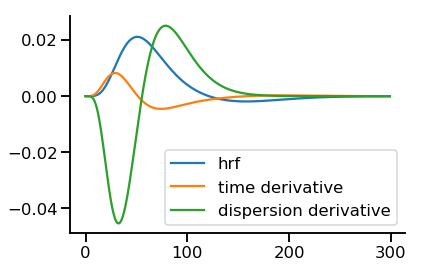

In [30]:
plt.plot(hrf,label='hrf')
plt.plot(time,label='time derivative')
plt.plot(dispersion,label='dispersion derivative')
plt.legend()
sns.despine()
plt.show()

### Simulierte Daten

In [31]:
time_period = hrf.shape[-1]
my_data = np.concatenate([np.zeros(30),hrf])[:time_period]

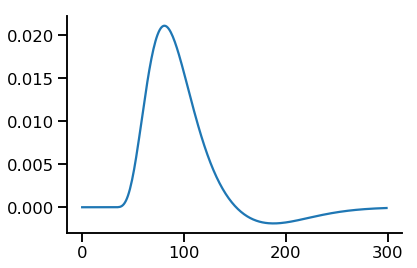

In [32]:
plt.plot(my_data)
sns.despine()
plt.show()

### interaktiver Plot

In [33]:
def make_plot(weight1,weight2,weight3):

    plt.plot(my_data)
    
    prediction1 = hrf*weight1
    prediction2 = time*weight2
    prediction3 = dispersion*weight3

    sum_of_predictions = prediction1 + prediction2 + prediction3
    plt.plot(sum_of_predictions,label='sum of preds')
    
    plt.plot(prediction1,'--',label='hrf')
    plt.plot(prediction2,'--',label='time')
    plt.plot(prediction3,'--',label='disp')
    
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [34]:
interact(make_plot,
         weight1=(-1.,1,0.01),
         weight2=(-2.,2,0.01),
         weight3=(-2.,2,0.01));

interactive(children=(FloatSlider(value=0.0, description='weight1', max=1.0, min=-1.0, step=0.01), FloatSlider…

### Design matrix

In [35]:
design_hrf = pd.DataFrame(dict(hrf=hrf))

In [36]:
design_hrf_time = pd.DataFrame(dict(hrf=hrf,
                                    time=time)
                              )

In [37]:
design_hrf_time_disp = pd.DataFrame(dict(hrf=hrf,
                                         time=time,
                                         disp=dispersion)
                                   )

In [38]:
design_dict = dict(design_hrf=design_hrf,
                   design_hrf_time=design_hrf_time,
                   design_hrf_time_disp=design_hrf_time_disp)

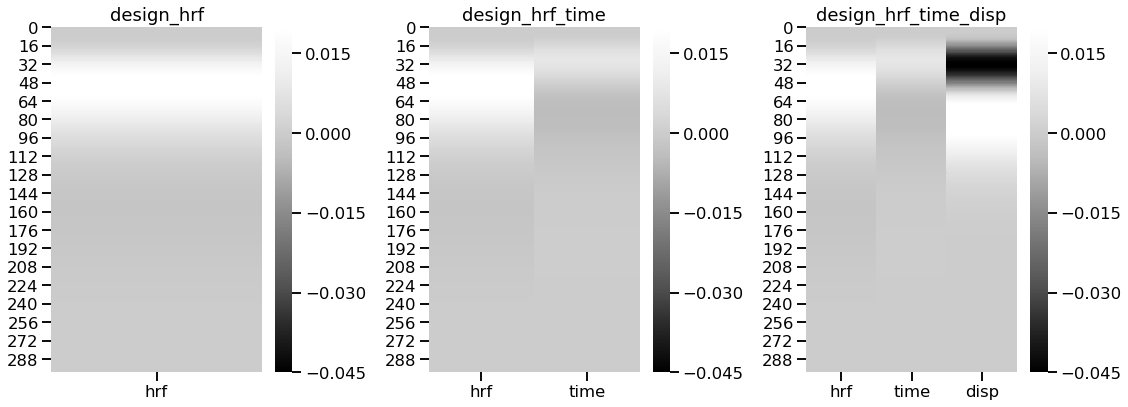

In [39]:
plt.figure(figsize=(16,6))
for i,design in enumerate(design_dict):
    ax = plt.subplot(131+i)
    sns.heatmap(design_dict[design],cmap='Greys_r',vmin=-0.045,vmax=0.02,ax=ax)
    ax.set_title(design)
plt.tight_layout()
plt.show()

### Bester fit

In [40]:
my_results = regression.OLSModel(design_dict['design_hrf']).fit(my_data)

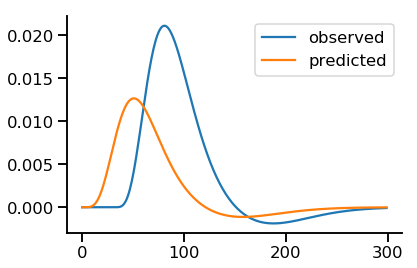

In [41]:
plt.plot(my_data,label='observed')
plt.plot(my_results.predicted,label='predicted')
plt.legend()
sns.despine()
plt.show()

### Abbildung mit Daten, Fit und Residuen

In [42]:
def make_one_plot(my_data,my_results,my_title,ax1,ax2):
    
    # main plots
    ax1.plot(my_data,label='observed')
    ax1.plot(my_results.predicted,linestyle='--',label='predicted')
    ax2.plot(my_results.wresid,label='residual',color='r')
    
    ### results
    
    # beta
    beta = my_results.theta[0]
    
    # t
    zeros = np.zeros(my_results.theta.shape[-1])
    zeros[0] = 1
    t = my_results.Tcontrast(zeros).t

    # ax1 aesthetics
    ax1.set_ylim(-0.01,0.03)
    ax1.axhline(0,color='k')
    ax1.legend()
    ax1.set_title(my_title)
    
    # ax2 aesthetics
    ax2.axhline(0,color='k')
    ax2.set_ylim(-.02,.02)
    ax2.set_title('beta=%.2f, t=%.2f'%(beta,t))
    ax2.legend()
    sns.despine()
    
    return ax1,ax2

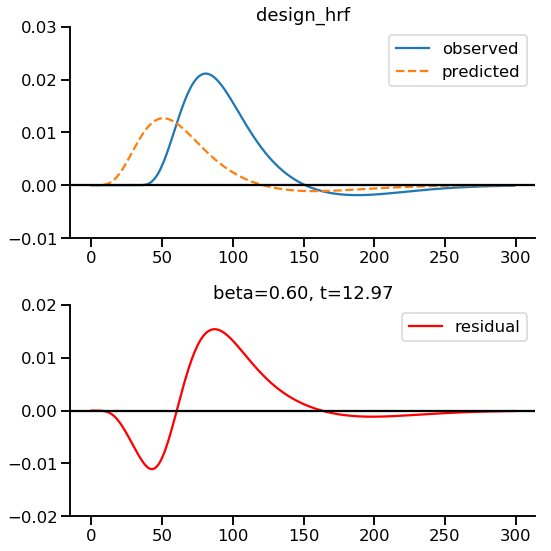

In [43]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
design_name = 'design_hrf'
my_model = regression.OLSModel(design_dict[design_name])
my_results = my_model.fit(my_data)
ax1,ax2 = make_one_plot(my_data,my_results,design_name,ax1,ax2)
plt.tight_layout()
plt.show()

### Abbildung mit verschiedenen Modellen

In [44]:
def make_big_plot(my_shift):
    
    my_data = np.concatenate([np.zeros(my_shift),hrf])[:time_period]

    fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,8))

    design_name = 'design_hrf'
    my_model = regression.OLSModel(design_dict[design_name])
    my_results = my_model.fit(my_data)
    ax1,ax4 = make_one_plot(my_data,my_results,design_name,ax1,ax4)

    design_name = 'design_hrf_time'
    my_model = regression.OLSModel(design_dict[design_name])
    my_results = my_model.fit(my_data)
    ax2,ax5 = make_one_plot(my_data,my_results,design_name,ax2,ax5)

    design_name = 'design_hrf_time_disp'
    my_model = regression.OLSModel(design_dict[design_name])
    my_results = my_model.fit(my_data)
    ax3,ax6 = make_one_plot(my_data,my_results,design_name,ax3,ax6)

    plt.tight_layout()
    plt.show()

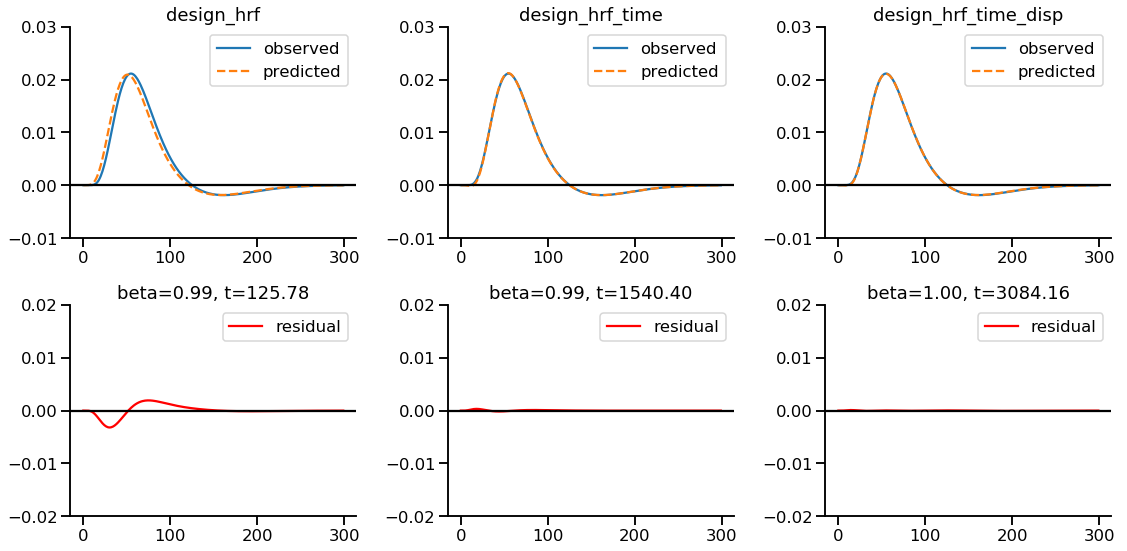

In [45]:
make_big_plot(my_shift=4)

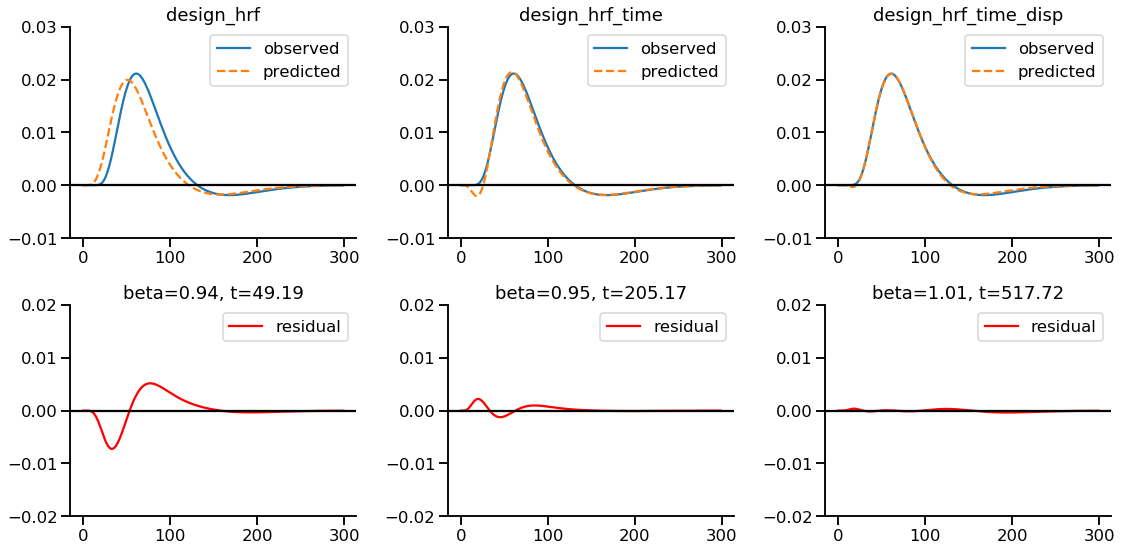

In [46]:
make_big_plot(my_shift=10)

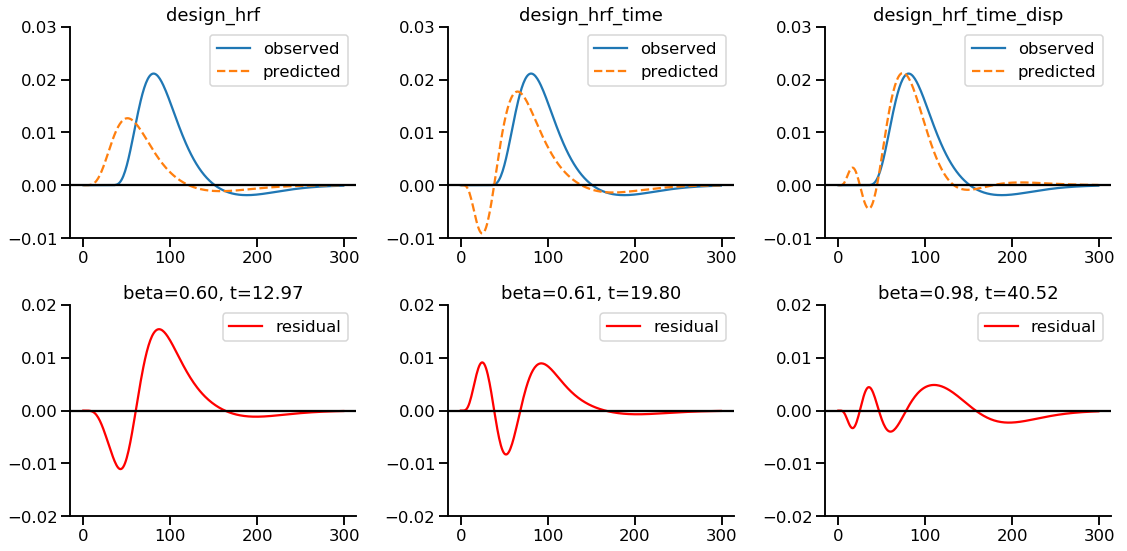

In [47]:
make_big_plot(my_shift=30)

### Interaktive Version

In [24]:
interact(make_big_plot,
         my_shift=ipywidgets.IntSlider(min=0,max=60,step=1,value=0));

interactive(children=(IntSlider(value=0, description='my_shift', max=60), Output()), _dom_classes=('widget-int…